***Задача 2. Node embeddings***

**Задачи:**

1. Найти набор данных для бинарной классификации рёбер в графе.
2. Реализовать случайные блуждания алгоритма DeepWalk и построить множества схожих вершин
3. Обучить эмбеддинги вершин, используя SGD и negative sampling.
4. Визуализировать эмбеддинги.
5. (+5 баллов) Также реализовать node2vec блуждания и обучить классификатор, используя его. Сравнить результаты.

In [1]:
import numpy as np
import pandas as pd
import random

import networkx as nx

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from collections import Counter

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

**Выберем граф**. <br>
Возьмём клуб карате, ка на практических занятиях

In [2]:
# загружаем граф
G = nx.karate_club_graph()

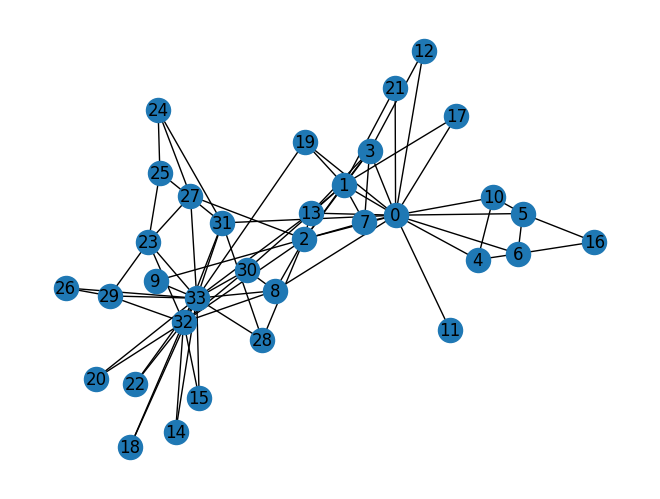

In [ ]:
# Отображаем граф
nx.draw(G, with_labels = True)

**Реализуем случайные блуждания алгоритма DeepWalk**

In [3]:
# Порядок работы функции:
# В качестве аргумента функция принимает сам граф.
# Основная часть функции - это цикл с чослом итераций равном количеству вершин переданного графа.
# Внутри основного цикла функции вложены два внутренних цикла:
# первый из них (он же внешний для второго) ограничен максимально заданным количеством путей для блуждания,
# второй ограничен максимально заданным количеством шагов по текущему пути.
# В данном цикле с помощью стандартнйо функции neighbors() библиотеки networkx составляется список
# вершин, являющихся соседними для данной вершины.
# Далее из этого списка при помощи random случайным образом выбирается следующая вершина для обхода.
# Посредством такого обхода фурмируются два списка: достижимых и недостижимых вершин,
# которые возвращаются функцией как результат работы, также функция возвращает эмбединги,
# используемые моделью.


def DeepWalk(G):
  num_of_paths = 10
  len_of_path = 10
  rand_nodes = 5
  num_of_nodes = G.number_of_nodes()
  emb = torch.nn.Embedding(num_embeddings = num_of_nodes, embedding_dim = num_of_nodes)
  positive_nodes = []
  negative_nodes = []
  for i in range(num_of_nodes):
    temp_emb = np.zeros(num_of_nodes)
    temp_pos_nodes = []
    temp_neg_nodes = np.zeros(rand_nodes)
    for j in range(num_of_paths):
      temp_node = i
      nodes_in_path = set()
      nodes_in_path.add(temp_node)
      for k in range(len_of_path):
        avail_neighb = []
        for neighb in G.neighbors(temp_node):
          avail_neighb.append(neighb)
        next_node = random.choice(avail_neighb)
        nodes_in_path.add(next_node)
        temp_node = next_node
      for nodes in nodes_in_path:
        temp_emb[nodes] += 1
        temp_pos_nodes.append(nodes)
    neg_samples = []
    for j in range(len(temp_emb)):
      if temp_emb[j] == 0 :
        neg_samples.append(j)
    for j in range(rand_nodes):
      temp_neg_nodes[j] = random.choice(neg_samples)

    emb.weight.data[i] = torch.Tensor(temp_emb / num_of_paths)
    positive_nodes.append(temp_pos_nodes)
    negative_nodes.append(temp_neg_nodes)

  return emb, positive_nodes, np.array(negative_nodes)

In [4]:
# Вызываем функцию DeepWalk и сохраняем результаты в переменные

emb, pos_nodes, neg_nodes = DeepWalk(G)

In [5]:
# Функция снижает размерность пространства эмбедингов в помощью PCA
# Осуществляет грфаический вывод.
# Функция взята из блокнота практики

plt.rcParams['figure.facecolor'] = (0.5, 0.5, 0.5)
plt.rcParams['axes.facecolor'] = (0.75, 0.75, 0.75)

def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(10, 10))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="brown", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="green", label="John A")
  plt.legend()
  plt.show()


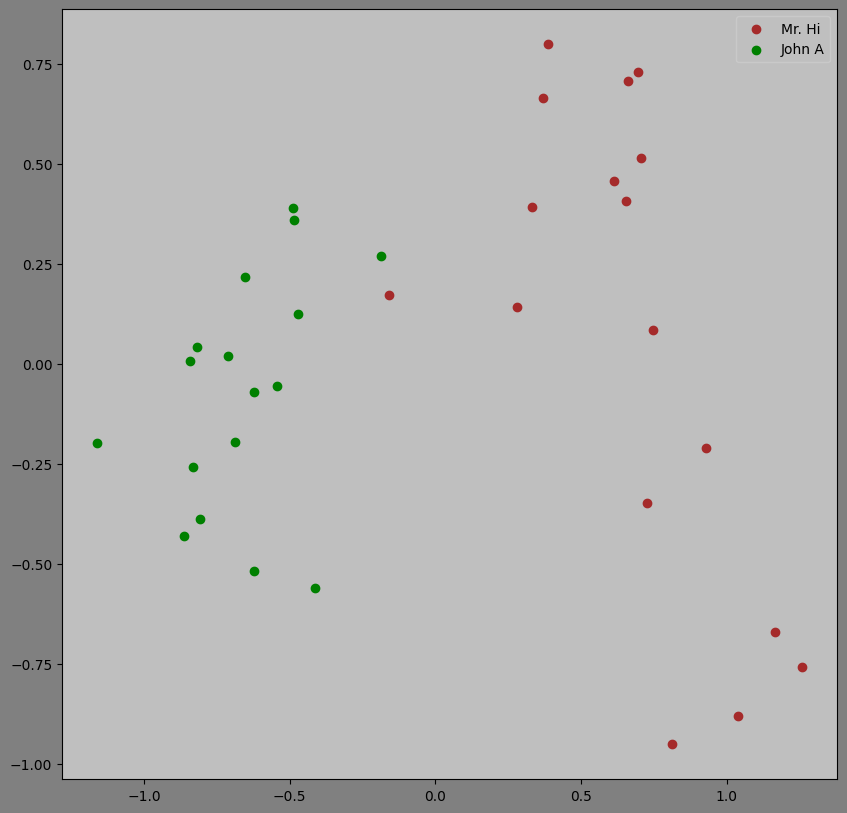

In [6]:
visualize_emb(emb)

Можем видеть, что приведя эмбединги к двухмерному пространству, можно получить визуально разделимые классы без дополнительной обработки данных.

**Введём функцию потерь**

In [7]:
# Порядок работы функции
# Основная часть функции - цикл размера пространства набора эмбедингов.
# В данном цикле проходится два цикла по позитивным и негативным вершинам,
# списки которых были составлены ранее и передаются в данную функцию
# в качестве аргументов

def Loss(emb, pos_nodes, neg_nodes):
  V = len(emb.weight.data)
  total_loss = 0
  for u in range(V):
    Nr_u = pos_nodes[u]
    for v in Nr_u:
      ZuT_Zv = torch.sum(torch.mul(emb.weight[u], emb.weight[int(v)]), axis = 0)
      total_loss += torch.log(torch.sigmoid(ZuT_Zv))
      k = neg_nodes[u]
    for i in k:
      ZuT_ZTi = torch.sum(torch.mul(emb.weight[u], emb.weight[int(i)]), axis = 0)
      total_loss += torch.log(torch.sigmoid(-ZuT_ZTi))
  total_loss = -total_loss
  return total_loss

**Функция для обучения**

In [8]:
# Порядок работы функции
# Используется стандартная схема функции обучения.
# Проходится 100 эпох,
# Оптимизатор - СГД
# Каждые 20 эпох выводится значение функции потерь и
# графическое отображение разделяемых классов

def train(emb, pos_nodes, neg_nodes):
  epochs = 100
  learning_rate = 0.01
  optimizer = torch.optim.SGD(emb.parameters(), lr = learning_rate, momentum = 0.9)
  for i in range(epochs):
    optimizer.zero_grad()
    loss = Loss(emb, pos_nodes, neg_nodes)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      if i % 20 == 0:
        print(loss)
        visualize_emb(emb)

**Запускаем обучение**

tensor(550.9030, grad_fn=<NegBackward0>)


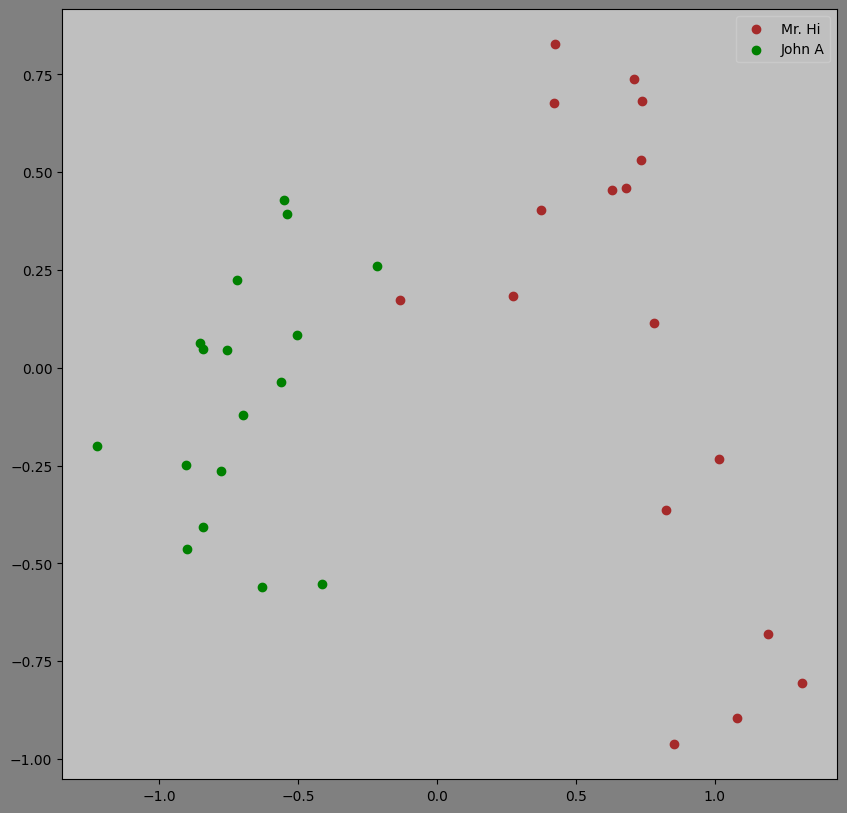

tensor(221.3367, grad_fn=<NegBackward0>)


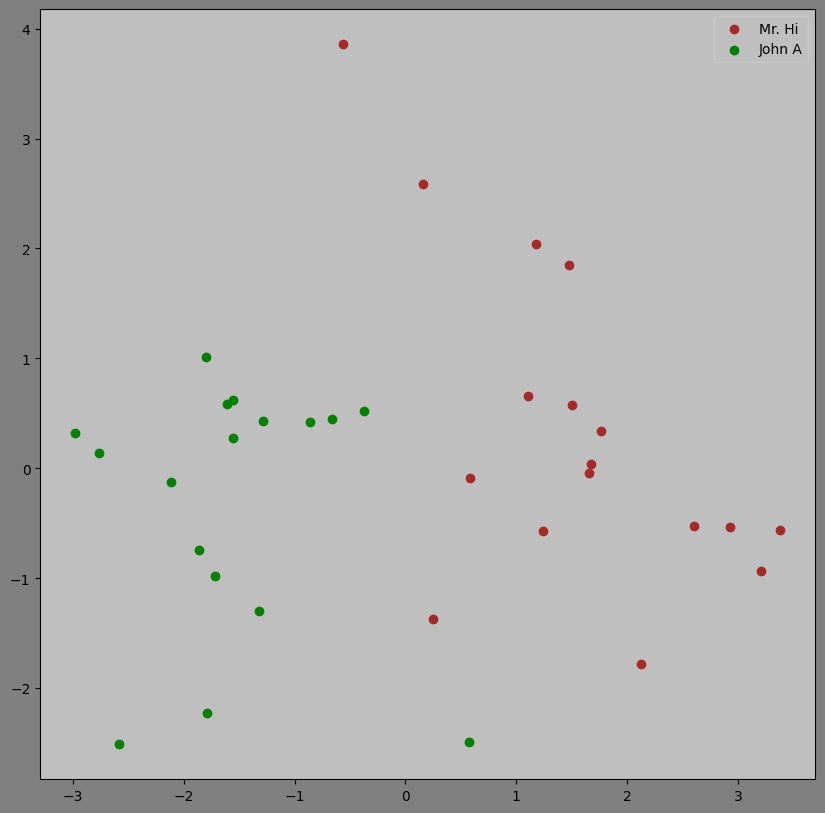

tensor(198.1435, grad_fn=<NegBackward0>)


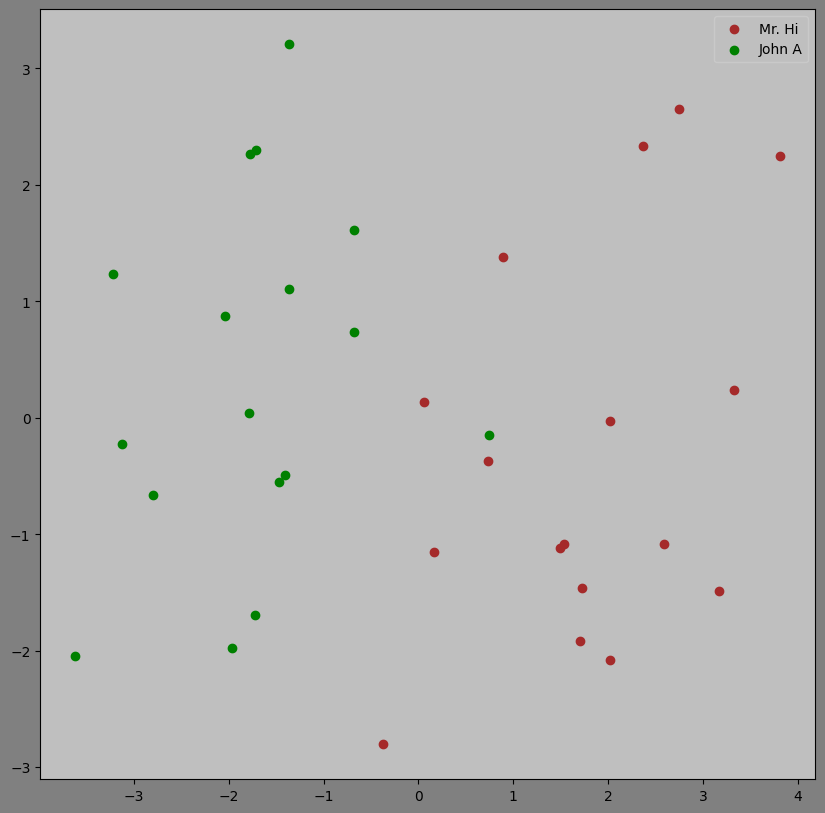

tensor(195.9030, grad_fn=<NegBackward0>)


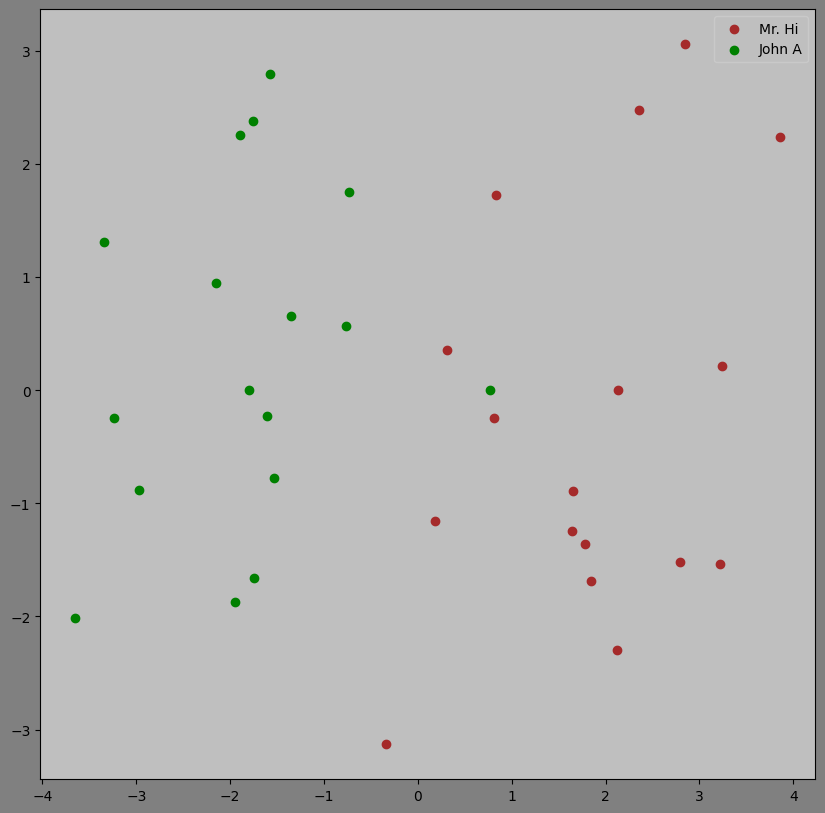

tensor(195.5660, grad_fn=<NegBackward0>)


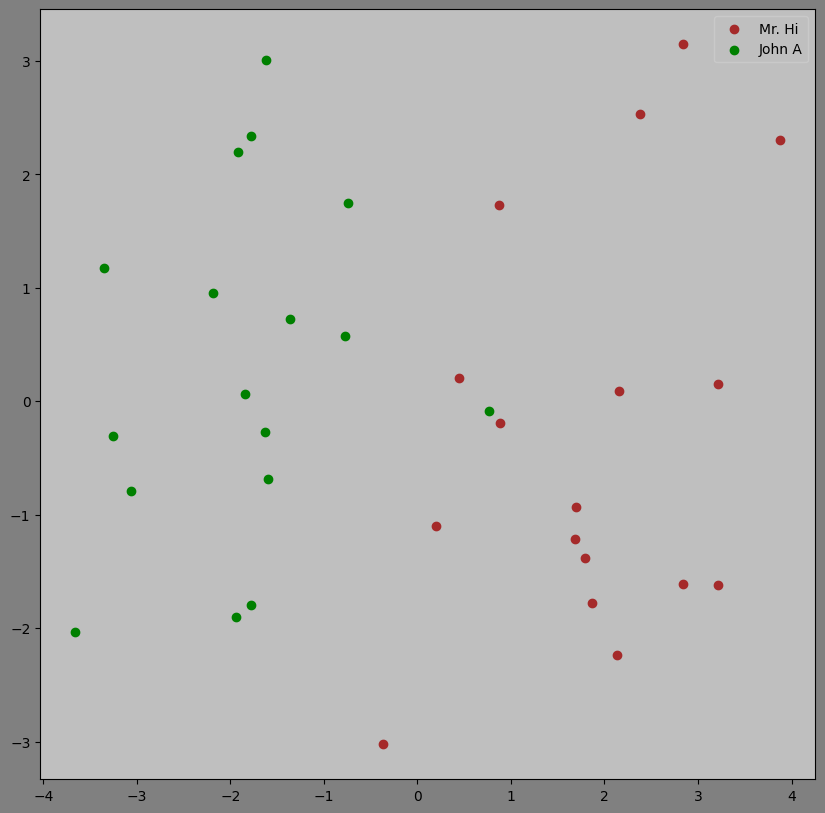

In [9]:
train(emb, pos_nodes, neg_nodes)

**Выводы по первой части**

С увеличением количества эпох обучения снижается значение функции потерь, что свидетельствует о том, что модель построена корректно. <br> На графическом представлении результатов два класса вполне отчётливо разделимы.

**Дополнительное задание (+5 баллов)**

**Реализация node2vec**

Алгоритм Node2Vec похож на алгоритм DeepWalk. Разница заключается в том, что Node2Vec учитывает вероятность возвращаемости к вершинам при случайном блуждании.

In [10]:
# Порядок работы функции аналогичен функции из первой части работы
# Здесь появляются две дополнительные переменные, вводящие в функцию вероятности.
# p определяет вероятность возврата к этой же вершине.
# q определяет вероятность перехода к вершинам, которые не являются соседями вершины,
# из которой перешли


def Node2Vec(G):
  num_of_paths = 10
  len_of_path = 10
  rand_nodes = 5
  p = 1
  q = 0.5
  num_of_nodes = G.number_of_nodes()
  emb = torch.nn.Embedding(num_embeddings = num_of_nodes, embedding_dim = num_of_nodes)
  positive_nodes = []
  negative_nodes = []
  for i in range(num_of_nodes):
    temp_emb = np.zeros(num_of_nodes)
    temp_pos_nodes = []
    temp_neg_nodes = np.zeros(rand_nodes)
    pred_node = i
    avail_neighb_pred_node = set()
    for j in range(num_of_paths):
      temp_node = i
      nodes_in_path = set()
      nodes_in_path.add(temp_node)

      for k in range(len_of_path):
        avail_neighb = []
        for neighb in G.neighbors(temp_node):
          if neighb == pred_node:
            for f in range(int(1/p)):
              avail_neighb.append(neighb)
          elif neighb in avail_neighb_pred_node:
            avail_neighb.append(neighb)
          else:
            for f in range(int(1/q)):
              avail_neighb.append(neighb)
        next_node = random.choice(avail_neighb)
        pred_node = temp_node
        nodes_in_path.add(next_node)
        temp_node = next_node
        for f in range(len(avail_neighb)):
          avail_neighb_pred_node.add(avail_neighb[f])

      for nodes in nodes_in_path:
        temp_emb[nodes] += 1
        temp_pos_nodes.append(nodes)
    neg_samples = []
    for j in range(len(temp_emb)):
      if temp_emb[j] == 0 :
        neg_samples.append(j)
    for j in range(rand_nodes):
      temp_neg_nodes[j] = random.choice(neg_samples)

    emb.weight.data[i] = torch.Tensor(temp_emb / num_of_paths)
    positive_nodes.append(temp_pos_nodes)
    negative_nodes.append(temp_neg_nodes)

  return emb, positive_nodes, np.array(negative_nodes)

In [11]:
emb2, pos_nodes2, neg_nodes2 = Node2Vec(G)

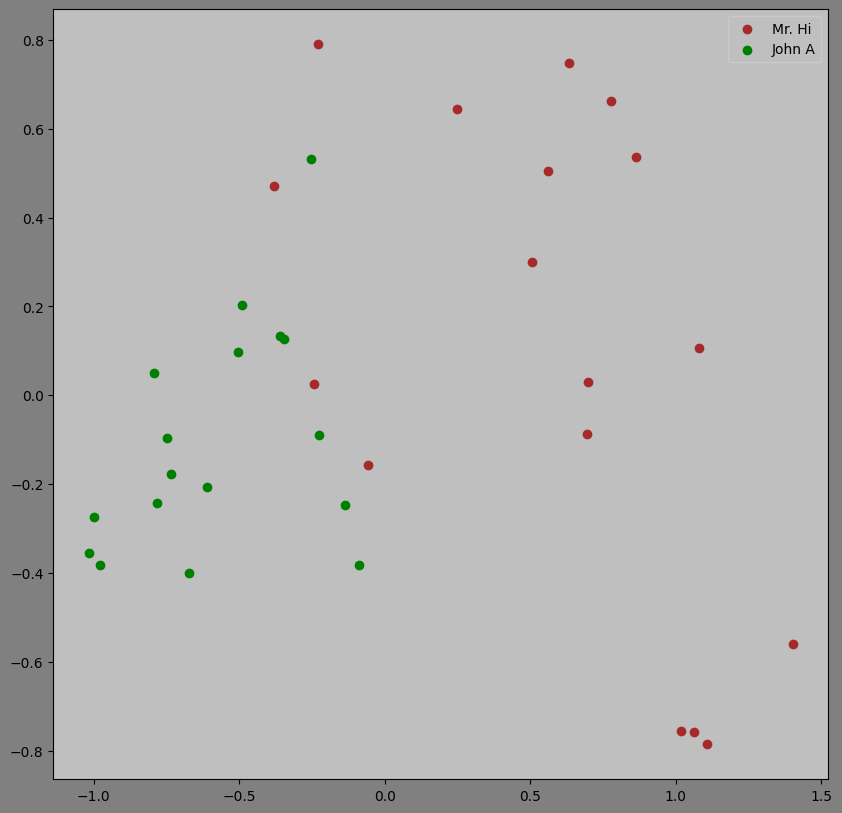

In [12]:
visualize_emb(emb2)

tensor(531.9368, grad_fn=<NegBackward0>)


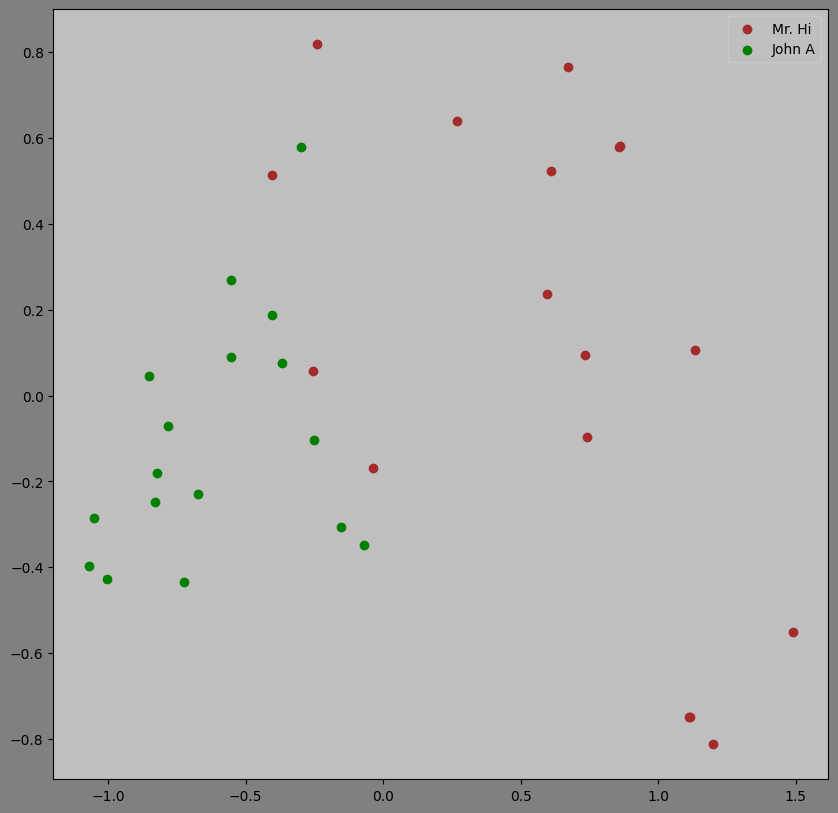

tensor(192.2938, grad_fn=<NegBackward0>)


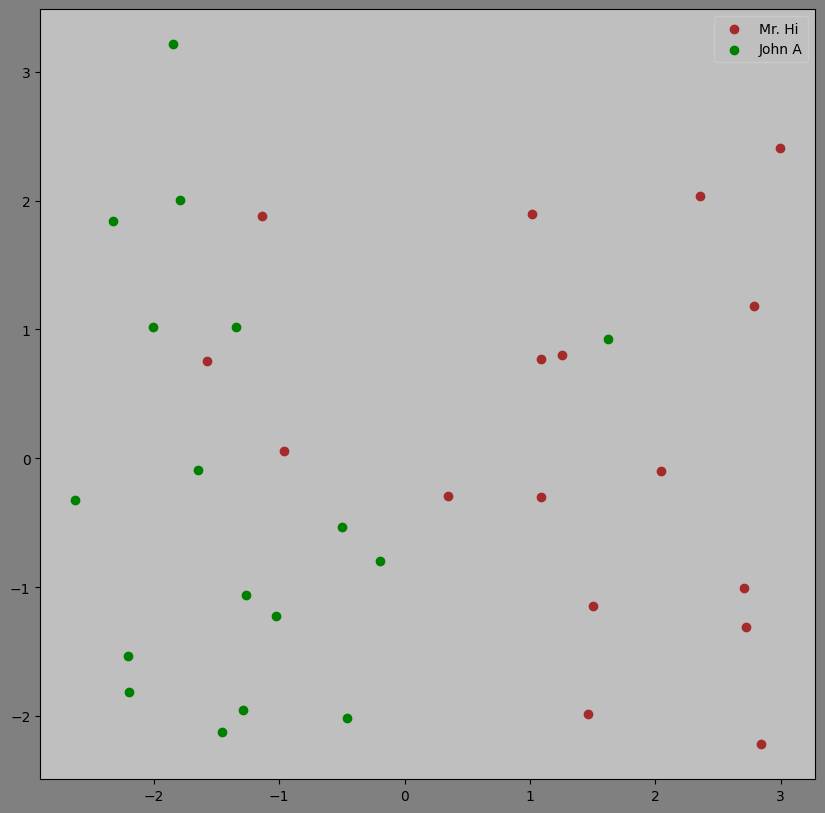

tensor(175.3388, grad_fn=<NegBackward0>)


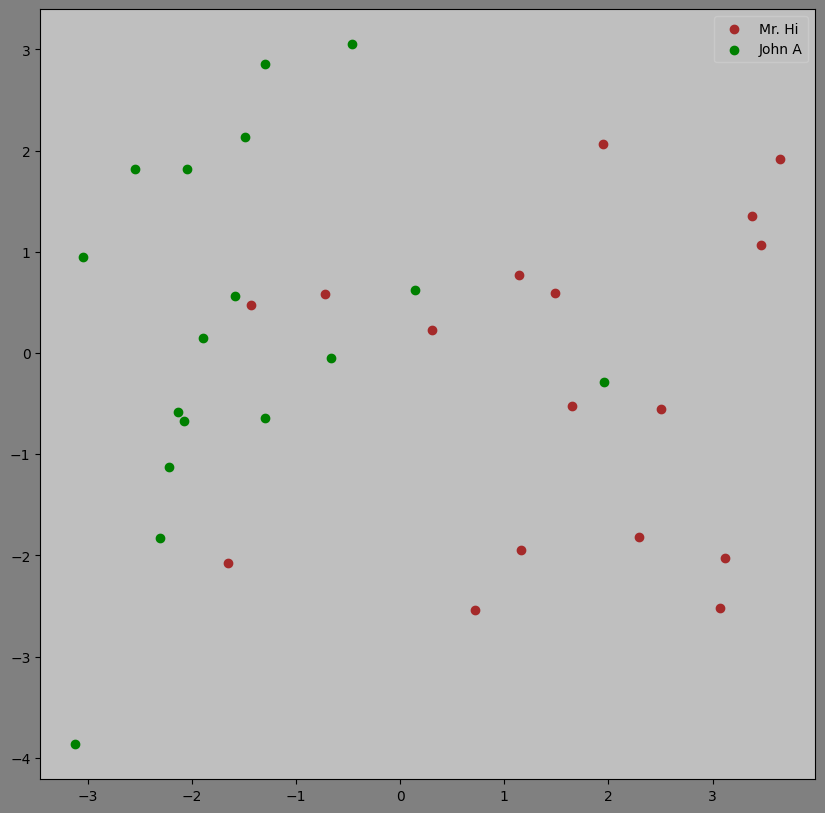

tensor(173.3960, grad_fn=<NegBackward0>)


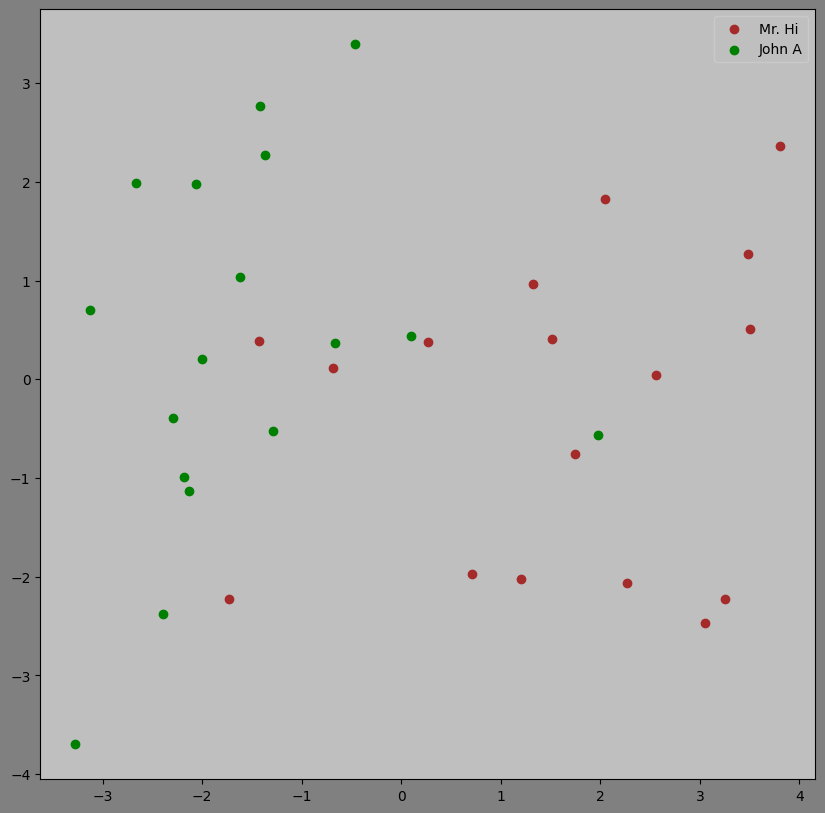

tensor(173.0840, grad_fn=<NegBackward0>)


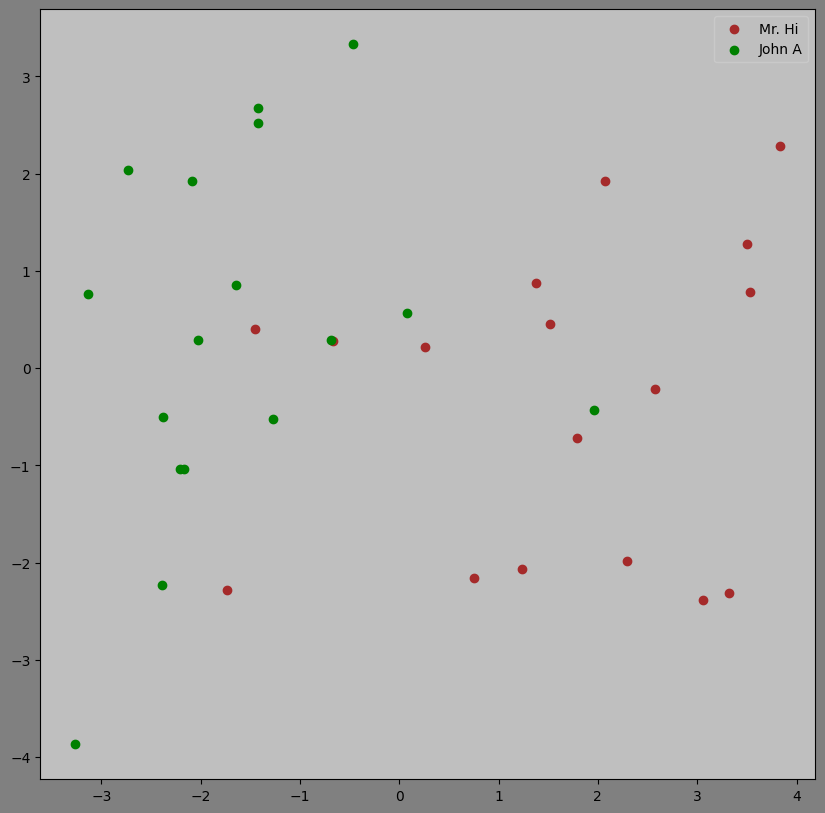

In [13]:
# Запустим обучение модели, используя для этого функцию обучения из первой части работы

train(emb2, pos_nodes2, neg_nodes2)

**Выводы**

По значениям функции потерь алгоритм Node2Vec показывает более качественные результаты работы.
<br>
Так, по завершении 100 эпох обучения значение функции потерь у алгоритма DeepWalk составляет 195, а у алгоритма Node2Vec 173 - разница вполне существенна.
<br> При этом, судя по значениям функции потерь, примерно после середины процесса обучения значение функции потерь убывает крайне медленно, что может свидетельствовать о том, что для данного набора данных (в данном случае - эмбедингов) 100 эпох обучеия являются излишними.